# 1. Academic Phrasebank

https://www.phrasebank.manchester.ac.uk/

General resources for "academic" phrases for academic writers. The resource should be particularly useful for writers who need to report their research work.

# 2. OpenAI Gym

https://gym.openai.com/docs/

The gym library is a collection of test problems — *environments* — that you can use to work out your reinforcement learning algorithms.

In layman's term:
- **Reinforcement Learning**: A Machine Learning paradigm that involves training an *agent* to take *actions* in an *environment*, in order to maximize some *reward*.
    + Example 1: Training [AlphaGo](https://www.deepmind.com/research/highlighted-research/alphago) to play a game of Go and earn reward if it makes a move that wins the chess match.  
    + Example 2: Training [Alphastar](https://www.deepmind.com/blog/alphastar-grandmaster-level-in-starcraft-ii-using-multi-agent-reinforcement-learning) to play Starcraft II
    
- **Environment**: Can be roughly understood as a "game" that the agent is trained to master. The agent will play this game over and over to master it. Each "playthrough" is called an *episode*

In [1]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

## Warm-up example: Cart Pole

*Goal: The pendulum starts upright, and the goal is to prevent it from falling over. The system is controlled by applying a force of +1 or -1 to the cart.*

*Reward: A reward of +1 is provided for every timestep that the pole remains upright.* 

*Episode: The episode ends when the game is over (the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.)*

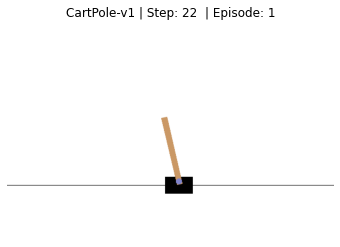

Episode finished after 23 timesteps


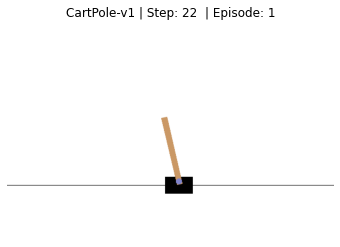

In [2]:
def show_state(env, episode, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("%s | Step: %d %s | Episode: %d" % (env.spec.id,step, info, episode))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())
    
def first_demonstration():
    env = gym.make('CartPole-v1')
    for i_episode in range(2):
        observation = env.reset()
        for t in range(50):
            env.render()
            action = env.action_space.sample()
            observation, reward, done, info = env.step(action)
            show_state(env,step=t, episode = i_episode)
            if done:
                print("Episode finished after {} timesteps".format(t+1))
                break
    env.close()
    return None

first_demonstration()

## Build a model to train our Agent to play Cart Pole

tl,dr: Q-Learning, with CNN 

In [3]:
env = gym.make('CartPole-v1').unwrapped

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
### Replay Memory

"""
Experience replay memory: At time t, the agent's experience e_t is defined as the tuple 
e_t = (s_t, a_t, r_(t+1), s_(t+1)). All of the agent's experiences at each time step over 
all episodes played by the agent are stored in the replay memory (or normally N last experiences).

This replay memory data set is what we'll randomly sample from to train the network. 
A key reason for using replay memory is to break the correlation between consecutive samples.

- Transition: a named tuple representing a single transition in our environment. 
    It essentially maps (state, action) pairs to their (next_state, reward) result, 
    with the state being the screen difference image as described later on.
- ReplayMemory: a cyclic buffer of bounded size that holds the transitions observed recently. 
    It also implements a .sample() method for selecting a random batch of transitions for training.
"""


Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [5]:
"""
https://colab.research.google.com/drive/1eN33dPVtdPViiS1njTW_-r-IYCDTFU7N#scrollTo=WNaOc4flcOl2

Q-Learning Theory: 

Our aim will be to train a policy pi that tries to maximize the discounted, cumulative reward R
The main idea behind Q-learning is that if we had a function Q*: State x Action → Real
that could tell us what our return would be if we were to take an action in a given state,
then we could easily construct a policy that maximizes our rewards:

pi*(s) = argmax Q*(s,a)
            a
every Q function for some policy obeys the Bellman equation
The difference between the two sides of the equality is known as the temporal difference error
We seek to minimise the temporal difference error using Huber loss 
"""

'\nhttps://colab.research.google.com/drive/1eN33dPVtdPViiS1njTW_-r-IYCDTFU7N#scrollTo=WNaOc4flcOl2\n\nQ-Learning Theory: \n\nOur aim will be to train a policy pi that tries to maximize the discounted, cumulative reward R\nThe main idea behind Q-learning is that if we had a function Q*: State x Action → Real\nthat could tell us what our return would be if we were to take an action in a given state,\nthen we could easily construct a policy that maximizes our rewards:\n\npi*(s) = argmax Q*(s,a)\n            a\nevery Q function for some policy obeys the Bellman equation\nThe difference between the two sides of the equality is known as the temporal difference error\nWe seek to minimise the temporal difference error using Huber loss \n'

In [6]:
### Q-network

"""
Our model will be a convolutional neural network that takes in the difference between the current and previous 
screen patches. It has two outputs, representing Q(s,left) and Q(s,right) (where ss is the input to the network). 
In effect, the network is trying to predict the expected return of taking each action given the current input.
"""

class DQN(nn.Module):

    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

/home/son.ha/anaconda3/envs/myenv/lib/python3.9/site-packages/torchvision/transforms/transforms.py:280: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


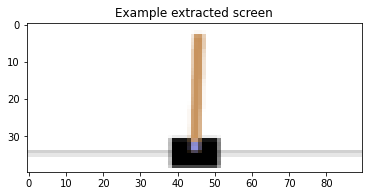

In [7]:
"""
The code below are utilities for extracting and processing rendered images from the environment. 
It uses the torchvision package, which makes it easy to compose image transforms. 
Once you run the cell it will display an example patch that it extracted.
"""

resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])


def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART

def get_screen():
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    # Cart is in the lower half, so strip off the top and bottom of the screen
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(screen_width)
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    # Strip off the edges, so that we have a square image centered on a cart
    screen = screen[:, :, slice_range]
    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0)


env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

In [8]:
"""
This cell instantiates our model and its optimizer, and defines some utilities:

select_action - will select an action accordingly to an epsilon greedy policy. 
Simply put, we’ll sometimes use our model for choosing the action, and sometimes we’ll just sample one uniformly. 
The probability of choosing a random action will start at EPS_START and will decay exponentially towards EPS_END. 
EPS_DECAY controls the rate of the decay.

plot_durations - a helper for plotting the durations of episodes, along with an average over the last 100 episodes(the
measure used in the official evaluations). The plot will be underneath the cell containing the main training loop,
and will update after every episode.
"""

BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

# Get screen size so that we can initialize layers correctly based on shape
# returned from AI gym. Typical dimensions at this point are close to 3x40x90
# which is the result of a clamped and down-scaled render buffer in get_screen()
init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

# Get number of actions from gym action space
n_actions = env.action_space.n

policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    #plt.title('Training...')
    #plt.xlabel('Episode')
    #plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())

In [9]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [10]:
def show_state(env, episode, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("%s | Step: %d %s | Episode: %d" % (env.spec.id,step, info, episode))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())

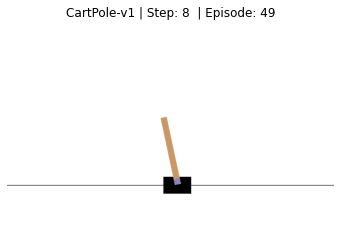

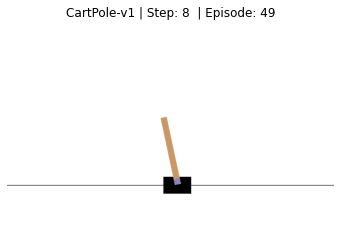

In [11]:
num_episodes = 50
for i_episode in range(num_episodes):
    # Initialize the environment and state
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    
    for t in count():
        show_state(env,step=t, episode = i_episode)
        # Select and perform an action
        action = select_action(state)
        _, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)

        # Observe new state
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()
        if done:
            episode_durations.append(t + 1)
            #plot_durations()
            break
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')
env.render()
show_state(env,step=t, episode = i_episode)
#env.close()
#plt.ioff()
#plt.show()

In [12]:
from gym import envs
envs.registry.all()

ValuesView(├──CartPole: [ v0, v1 ]
├──MountainCar: [ v0 ]
├──MountainCarContinuous: [ v0 ]
├──Pendulum: [ v1 ]
├──Acrobot: [ v1 ]
├──LunarLander: [ v2 ]
├──LunarLanderContinuous: [ v2 ]
├──BipedalWalker: [ v3 ]
├──BipedalWalkerHardcore: [ v3 ]
├──CarRacing: [ v1 ]
├──Blackjack: [ v1 ]
├──FrozenLake: [ v1 ]
├──FrozenLake8x8: [ v1 ]
├──CliffWalking: [ v0 ]
├──Taxi: [ v3 ]
├──Reacher: [ v2 ]
├──Pusher: [ v2 ]
├──InvertedPendulum: [ v2 ]
├──InvertedDoublePendulum: [ v2 ]
├──HalfCheetah: [ v2, v3 ]
├──Hopper: [ v2, v3 ]
├──Swimmer: [ v2, v3 ]
├──Walker2d: [ v2, v3 ]
├──Ant: [ v2, v3 ]
├──Humanoid: [ v2, v3 ]
└──HumanoidStandup: [ v2 ]
)